# PSF analysis on XZ Tau
We are really hoping to find that XZ Tau is made up of two sources. XZ Tau A and B are separated by about 0.3 arcsec, about 0.6 Chandra pixels. Thus, it's not inconcievable that we can find some sign of that, in particular if A and B have different spectral or timing probabilities. [Skinner and Güdel (2020)](https://ui.adsabs.harvard.edu/abs/2020ApJ...888...15S/abstract) observed XZ Tau in Chandra imaging already and note that the source is compatible with a point source. We hope that we can find something better than that - or at least be absolutely sure that they don't overlook anything. Compared to [Skinner and Güdel (2020)](https://ui.adsabs.harvard.edu/abs/2020ApJ...888...15S/abstract) we have more data (not a lot more photons, but a longer baseline where changes with the spectrum over time could happen), so it seems it might be worth the effort to try agian.

### What this is and what this is not
This *is* my personal notebook, akin to a lab book, where I write down what I tried. It's neither a vetting scientific publication, nor an official CXC "This is how you do that kind of analysis" thread.

In [424]:
import os
from glob import glob

from astropy.table import Table, vstack
from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy import stats as astats
from ciao_contrib.cda.data import download_chandra_obsids
from ciao_contrib import runtool as rt
import numpy as np
import pandas

import matplotlib.pyplot as plt
%matplotlib inline

In [138]:
XZTauObs = Table.read(rt.find_chandra_obsid('XZ Tau'), format='ascii.commented_header')

In [144]:
XZTauObs

obsid,sepn,inst,grat,time,obsdate,piname,target
int64,float64,str6,str4,float64,str10,str9,str17
1866,6.4,ACIS-I,NONE,78.9,2001-07-23,BALLY,LDN 1551N
5381,6.4,ACIS-I,NONE,96.9,2005-10-27,Favata,HH 154
5426,8.7,ACIS-S,NONE,10.8,2005-04-04,Weintraub,V710 Tau
11016,6.1,ACIS-S,NONE,65.2,2009-12-29,Schneider,HH 154
18915,0.4,ACIS-S,NONE,26.9,2018-01-06,Skinner,HL Tau
20160,0.2,ACIS-S,HETG,39.5,2018-10-26,Principe,XZ Tau and HL Tau
20161,0.2,ACIS-S,HETG,46.4,2018-10-28,Principe,XZ Tau and HL Tau
20906,0.4,ACIS-S,NONE,36.0,2017-12-27,Skinner,HL Tau
21946,0.2,ACIS-S,HETG,9.9,2018-10-24,Principe,XZ Tau and HL Tau


In [18]:
# I know that Schneider et al have found this effect in DG Tau.
# So, I grap one of those datasets, too, for comparison
Table.read(rt.find_chandra_obsid('DG Tau'), format='ascii.commented_header')

obsid,sepn,inst,grat,time,obsdate,piname,target
int64,float64,str6,str4,float64,str10,str6,str9
4487,0.6,ACIS-S,NONE,29.7,2004-01-11,Guedel,DG Tau AB
6409,0.4,ACIS-S,NONE,16.2,2005-12-15,Guedel,DG Tau
7246,0.4,ACIS-S,NONE,27.8,2006-04-12,Guedel,DG Tau
7247,0.4,ACIS-S,NONE,15.9,2005-12-17,Guedel,DG Tau
11009,0.4,ACIS-S,NONE,115.7,2010-01-05,Guedel,DG Tau
11010,0.4,ACIS-S,NONE,118.1,2010-01-08,Guedel,DG Tau
11011,0.4,ACIS-S,NONE,118.7,2010-01-02,Guedel,DG Tau


In [141]:
curdir = os.path.abspath(os.curdir)
os.chdir('data')
download_chandra_obsids(list(XZTauObs['obsid']), filetypes=['evt2'])
# One DG Tau dataset
download_chandra_obsids([11009], filetypes=['evt2'])
os.chdir(curdir)

In [143]:
# Astropy does not do well with the multiple WCS systems in Chandra evt2 files.
# https://github.com/astropy/astropy/issues/11413
# So, make a copy of the evt2 that only has one WCS using CIAO tools that handle 
# the initial multi-WCS situation correctly

for evt2file in glob('data/*/primary/acis*_evt2.fits.gz'):
    rt.dmcopy(infile=f'{evt2file}[cols time,x,y]', 
              outfile=f'{os.path.dirname(evt2file)}/clean_wcs.fits', clobber=True)

In [205]:
XZTaunames = ['XZ Tau', 'HLTau', 'HD 285845']
DGTaunames = ['DG Tau', 'FV Tau', '[BLH2002] KPNO-Tau 13']

In [63]:
# DG Tau hardcoded, because I had a power outage and needed to work offline...
# coord = SkyCoord('04:27:04.7 +26:06:15.7', unit=(u.hourangle, u.deg))

In [151]:
# rolled = pevt.rolling(100).aggregate(np.median)
# can be written as shorthand as
# rolled = pevt.rolling(100).median()
# However, the "aggregate" allows me to put in more complicated functions

def wrap_sigmaclip(df):
    return astats.sigma_clip(df).mean()

#rolled = pevt.rolling(100).aggregate(wrap_sigmaclip)

In [351]:
def obsid_wcs(obsid):
    '''Load evs file for OBSID and extract WCS
    
    Parameters
    ----------
    obsid : int
        Chandra ObsID
    
    Returns
    -------
    evtwcs : `astropy.wcs.WCS` object
    '''
    evtfile = glob(f'data/{obsid}/primary/acisf{obsid:05d}*evt2.fits.gz')
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FITSFixedWarning)
        evtwcs = WCS(fits.getheader(f'{os.path.dirname(evtfile[0])}/clean_wcs.fits', 'EVENTS'), 
                     keysel=['pixel'], naxis=['celestial'], fix=False)
    return evtwcs

In [352]:
import warnings
from astropy.wcs import FITSFixedWarning

def filter_evt(obsid, coos):
    '''Load an event file, and apply spatial and other filters
    
    Those other filters are set for common stellar paramters, notable
    energy < 8 keV. For ease of handling, the 'energy' columns is 
    rescaled to keV and the time column to time since first detected
    photon in ks.
    
    Parameters
    ----------
    obsid : int
        Chandra ObsID present in the data/ directory
    coos : list of astropy.SkyCoord 
        List of coordinates to extract. For every coordiante, an event list is 
        constructed for a circualr region with radius 10 pixels.
        
    Returns
    -------
    pevts : list of pandas dataframes
    '''
    evtfile = glob(f'data/{obsid}/primary/acisf{obsid:05d}*evt2.fits.gz')
    evts = Table.read(evtfile[0], hdu=1, format='fits')
    # and can also select only the colums we care for.
    # Saves some space when printing the table
    evts = evts['time', 'x', 'y', 'energy']
    # Last, make an energy filter. We know the high end is noise only.
    evts = evts[evts['energy'] < 8000]
    # turn energy to keV
    evts['energy'] /= 1000
    evts['time'] -= evts['time'][0]
    evts['time'] /=1000
    
    evtwcs = obsid_wcs(obsid)
    pevts = []
    for coo in coos:
        x0, y0 = evtwcs.all_world2pix(coo.ra, coo.dec, 1)
        evt = evts[np.sqrt((evts['x'] - x0)**2 + (evts['y'] - y0)**2) < 10]
        evt.sort('energy')
        pevts.append(evt.to_pandas())
    return pevts

In [549]:
def plot_evt(pevts, axes, col='energy', window=25, spacing=slice(None, None, 10), func=np.median):
    '''Construct matplotlib plots for positions of rolling median
    
    pevts : list of pandas dataframes
        Event lists
    axes : list of matplotlib axis 
    col : string
        column to sort and use rolling window on
    window : in or string
        see pandas.DataFrame.rolling
    spacing : slice
        Spacing of points in scatter plot. Default is to plot every
        thenth point
    func : callable
        Function to average points within a rolling window, e.g. np.mean or np.median
    '''
    for ax, pevt in zip(axes, pevts):
        #xmed = pevt['x'].median()
        #ymed = pevt['y'].median()
    
        pevt.sort_values(col)
        rolled = pevt.rolling(window).apply(func)
        scat = ax.scatter(rolled['x'][spacing], rolled['y'][spacing],
                          c=rolled[col][spacing], alpha=1)
        plt.colorbar(scat, ax=ax)
        x0, x1 = ax.get_xlim()
        #if x1 - x0 < 1:
        #    ax.set_xlim(-0.5, 0.5)
        #y0, y1 = ax.get_ylim()
        #if y1 - y0 < 1:
        #    ax.set_ylim(-0.5, 0.5) 

In [546]:
plt.set_cmap('hot')

<Figure size 432x288 with 0 Axes>

## Does the photocenter of the source depend on energy?

We do know from [Schneider & Schmitt (2008)](https://ui.adsabs.harvard.edu/abs/2008A%26A...488L..13S/abstract) that DG Tau has a jet that can be seen as an offset between the hard (coronal) and the soft (jet) photons. So, we'll first look at DG Tau, where we know what the anser is. In DG Tau, they took the four separate observations, cut them into two bands and calculated the photocenter in each band with uncertainties. That works great when the spectrum has an obvious break. We don't have that in the XZ Tau, so we use a varient of that: We sort the photons by energy and then calcuculate the mean (or meadian, see discussion below) for a ralling window. That way, we get a number of dots on the RA-Dec plot, not just two known bands. If soft energies are dominated by componenty and hard energies by the other, then the rolling mean/median RA/Dec values would move from one position to another at some energy.

We average instead of showing every photons, because the expected separation is less than the Chandra PSF, so we need to get the average position to reduce the noise. We could use separate bands, but instead opt for rolling windows because some observations do not have many photons. Rolling windows allow us to still plot *something* even if the dots shown in the plots are not statisitcially independent.

First, we try this out on a DG Tau dataset to see that we see a shift in postion in DG Tau, but not in other sources in the field.

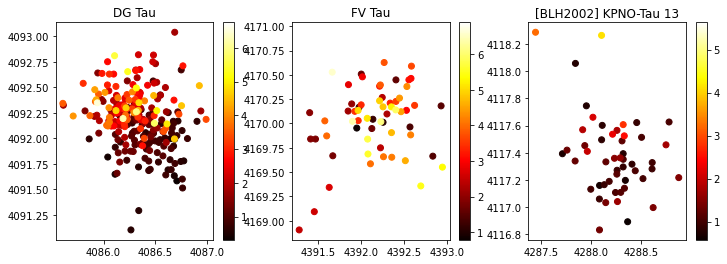

In [547]:
pevts = filter_evt(11009, [SkyCoord.from_name(n) for n in DGTaunames])

fig, axes = plt.subplots(figsize=(12, 4), ncols=3)
plot_evt(pevts, axes, func=np.mean)
for ax, t in zip(axes, DGTaunames):
    ax.set_title(t)

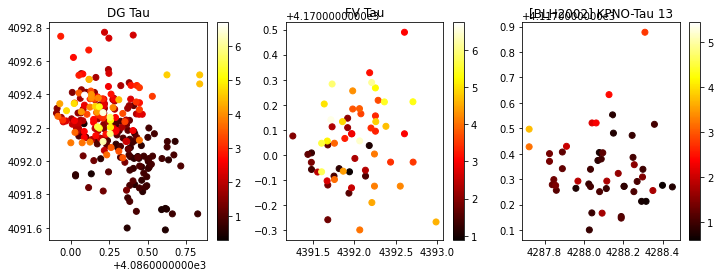

In [548]:
fig, axes = plt.subplots(figsize=(12, 4), ncols=3)
plot_evt(pevts, axes, func=np.median)
for ax, t in zip(axes, DGTaunames):
    ax.set_title(t)

Here, I'm making plots using different functions to average the results within a rolling window (mean on the top and median on the bottom). Median makes a narrows spot (look at the axis labels!) because it is more robust, i.e. less inflluencd by single outliers such as background photons that happen to fall into a window. On the other hand, "mean" gives bit of a smoother appearance.

In both cases, we do see a change in the DG Tau position with enerfy, but not in the other two sources, so we conclude that this method works and we now apply it to XZ Tau.

In [237]:
coos = [SkyCoord.from_name(n) for n in XZTaunames]

## Look at the relative position of XZ Tau A and B

Relative positions of XZ Tau A and B are given in the ALMA staudy from [Ichikawa et al. (2021)](https://arxiv.org/abs/2106.11924). Their table 4 lists positions for 2015-2017. Most of the Chandra data we have here is from 2018. The orbital motions is so small, in Chandra we won't see the difference, so I'll just plot the 2017 offset.

Our goal here is not to give the absolute coordiantes - we know that those are not necessarily right in Chandra and we don't have the best input coordiantes for XZ Tau anyway - but we want to show the direction in which an offset would be expected as well as the length. So, we use the SIMBAD position or "XZ Tau" (likely the photocenter or something like that) and make an arrow that represents the offset between DG Tau A and B in length and direction.

Note: The code above is slow because it's inefficient. File and filtering could be improved by keeing onty stuff in memory we really need and makeing sure we don't load more files then we really need. However, runtime is not a concern for me right now, so I won't bother to fix that.

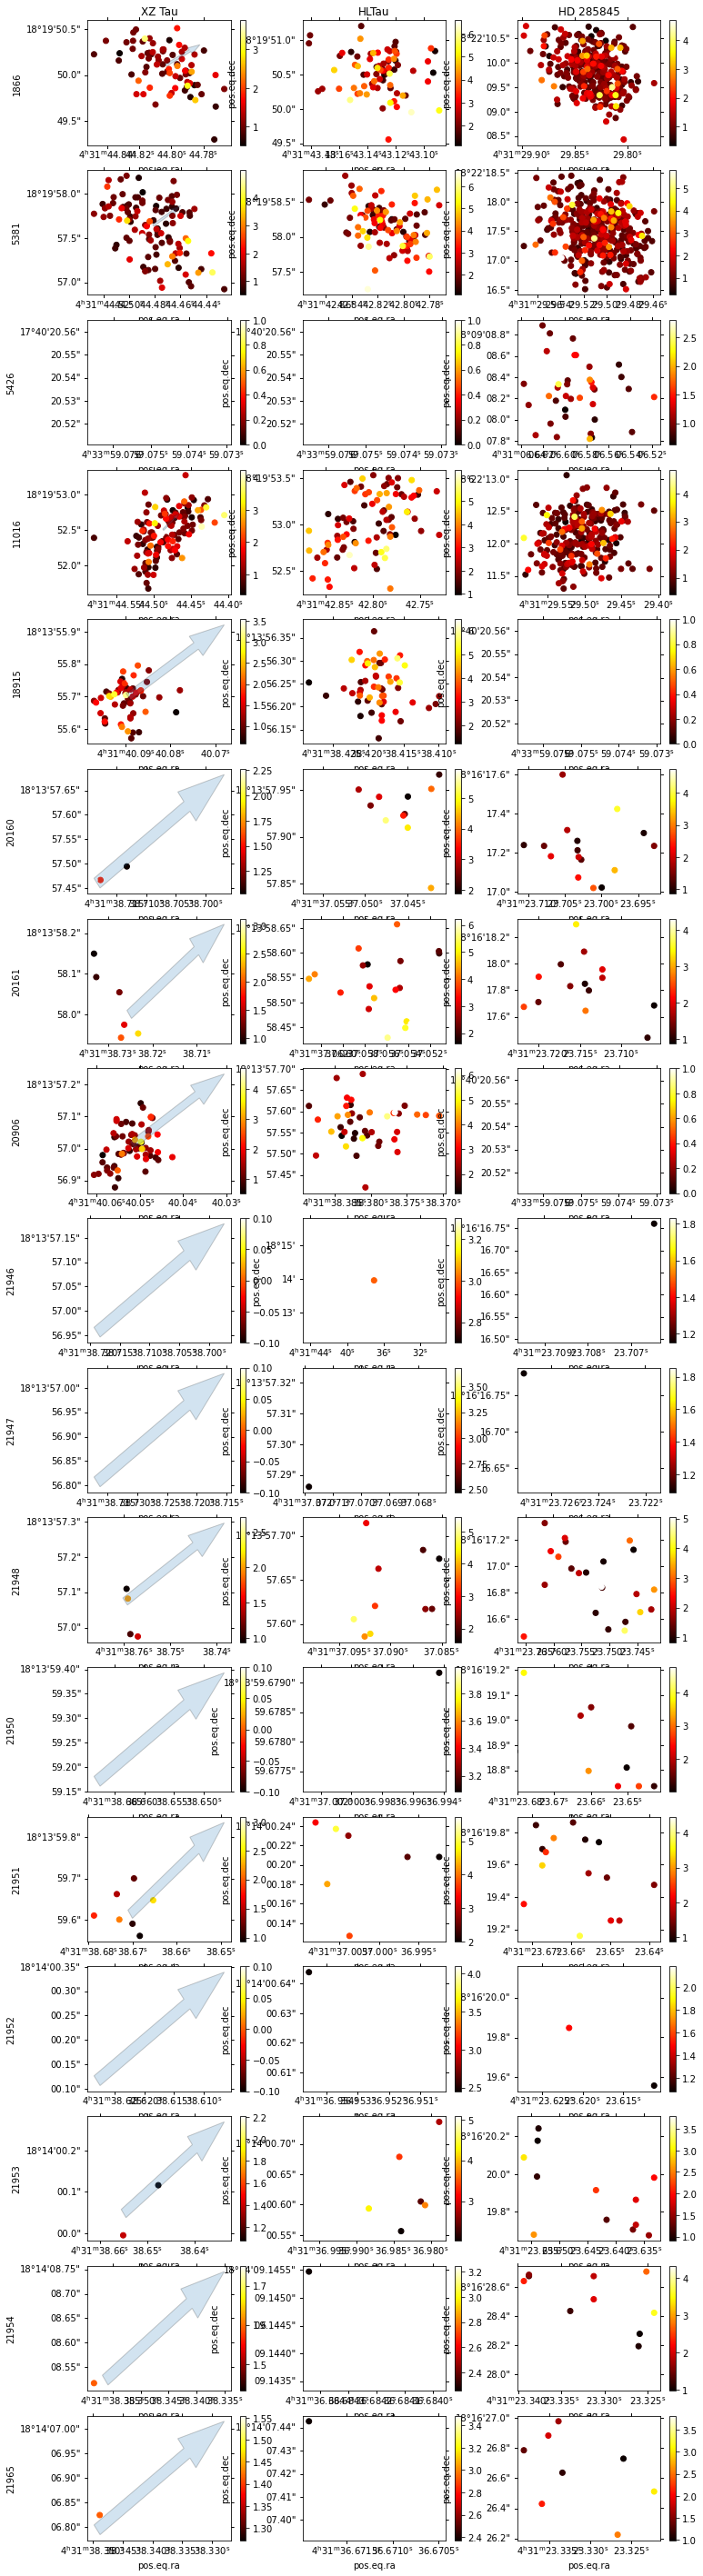

In [556]:
cooA = SkyCoord.from_name('XZ Tau')
cooB = cooA.spherical_offsets_by(-0.215 * u.arcsec, 0.157 * u.arcsec)

#fig, axes = plt.subplots(figsize=(12, len(XZTauObs) * 3), ncols=3, nrows=len(XZTauObs))
fig = plt.figure(figsize=(12, len(XZTauObs) * 3))
for i, o in enumerate(XZTauObs['obsid']):
    evtwcs = obsid_wcs(obsid)
    axes = [fig.add_subplot(len(XZTauObs), 3, i * 3 + j + 1, projection=evtwcs) for j in range(3)]
    pevts = filter_evt(o, coos)
    plot_evt(pevts, axes, window=50, spacing=slice(None, None, 25))
    axes[0].set_ylabel(o)
    
    # Add arrow for XZ Tau A -> B
    # Because absolute coordinates are not always right, start the arrow and the median xy position
    #x1, y1 = evtwcs.all_world2pix(cooA.ra, cooA.dec, 0)
    x1, y1 = pevts[0]['x'].median(), pevts[0]['y'].median()
    cooA = SkyCoord(*evtwcs.all_pix2world(x1, y1, 0), unit='deg')
    cooB = cooA.spherical_offsets_by(-0.215 * u.arcsec, 0.157 * u.arcsec)
    x2, y2 = evtwcs.all_world2pix(cooB.ra, cooB.dec, 0)
    axes[0].arrow(x1, y1, x2-x1, y2-y1, width=.05, alpha=.2)
    
    if i == 0:
        for ax, t in zip(axes, XZTaunames):
            ax.set_title(t)
#fig.axes[-1].set_label('energy [keV]')

The arrow in the plots above starts at the median RA/Dec position of all photons considered in that plot (but we only show the dots that average a rolling window, so no dot might be visible that that particular location) and the length and direction represent the offset fomr XZ Tau A -> B.
ObsID 20906 looks intriguing, but there is no clear general trend as we can see it in the DG Tau data above.

One idea might be to look at the width of the PSF. Of course, the width of teh PSF depends on the energy (and thus the spectrum of the source), the postions on the focal plane, the position angle on the sky for that particular observation etc. As marx developer, I currently don't trust marx to predict the PSF well enough to test his again simulations. Instead, I'll compare with HL Tau, which is close on the focal plane and not that different in spectrum. As a start, I'll do wha't easieat to code - just print out the standard deviation - and if I find hints of something interesting, I can look in more detail.

In [467]:
for i, o in enumerate(XZTauObs['obsid']):
    evtwcs = obsid_wcs(obsid)
    pevts = filter_evt(o, coos)
    print('OBSID:', o)
    print('x - std:', [pevt.x.std() for pevt in pevts])
    print('y - std:', [pevt.y.std() for pevt in pevts])

1866
x - std: [3.1515229, 3.247122, 3.756214]
y - std: [3.2677138, 3.4080439, 4.426796]
5381
x - std: [3.2932665, 3.258332, 3.7237117]
y - std: [3.2794118, 3.4445596, 4.32963]
5426
x - std: [nan, nan, 4.204011]
y - std: [nan, nan, 3.82744]
11016
x - std: [3.9707308, 3.9898157, 4.759841]
y - std: [3.318062, 3.2975452, 3.9640877]
18915
x - std: [1.3077365, 1.1690216, nan]
y - std: [1.2376189, 1.0992069, nan]
20160
x - std: [2.1584291, 1.5540456, 1.7316809]
y - std: [2.0965385, 1.3945919, 2.4595225]
20161
x - std: [1.829574, 1.3478403, 1.721755]
y - std: [1.8123046, 1.2690911, 2.7158704]
20906
x - std: [1.2145327, 1.264095, nan]
y - std: [1.2360282, 1.3180262, nan]
21946
x - std: [0.83177227, 2.2298589, 1.8791281]
y - std: [0.651826, 1.6210256, 2.5870903]
21947
x - std: [0.91279465, 1.4991008, 1.6184697]
y - std: [1.6997553, 1.857468, 2.7918546]
21948
x - std: [2.2133524, 1.7176894, 1.8090819]
y - std: [1.7845559, 1.3567528, 2.7360141]
21950
x - std: [1.5425771, 1.0186434, 1.9239367]
y - 

The first number of always XZ Tai, the second is HL Tau, the third some other source a little further away. The plot above shows that the XZ Tau A->B offset is roughty diagonal in XY, so we should see a little in both. The first few observations don't center on HL Tau or XZ Tau and thus the PSF is large.  

But even in the latter ones, I don't see a consistent pattern, e.g. in 20906 and 21496 XZ Tau is narrower than HL Tau in both x and y, while in 20106 and 20161 the opposite is the case. In some of the others, XZ Tau is narrower in one dimentions and HL Tau in the other.

## Time

What we did above for energy (see of the photocenter changes with energy) can also be done for time. If we see a blend of two sources and one of them flares, then the photocenter will shift as one source becomes brighter.

In [259]:
out = plt.set_cmap('viridis')

<Figure size 432x288 with 0 Axes>

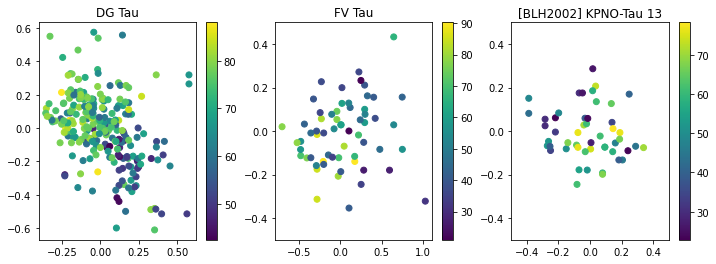

In [260]:
fig, axes = plt.subplots(figsize=(12, 4), ncols=3)

pevts = filter_evt(11009, [SkyCoord.from_name(n) for n in DGTaunames])
plot_evt(pevts, axes, 'time')
for ax, t in zip(axes, DGTaunames):
    ax.set_title(t)

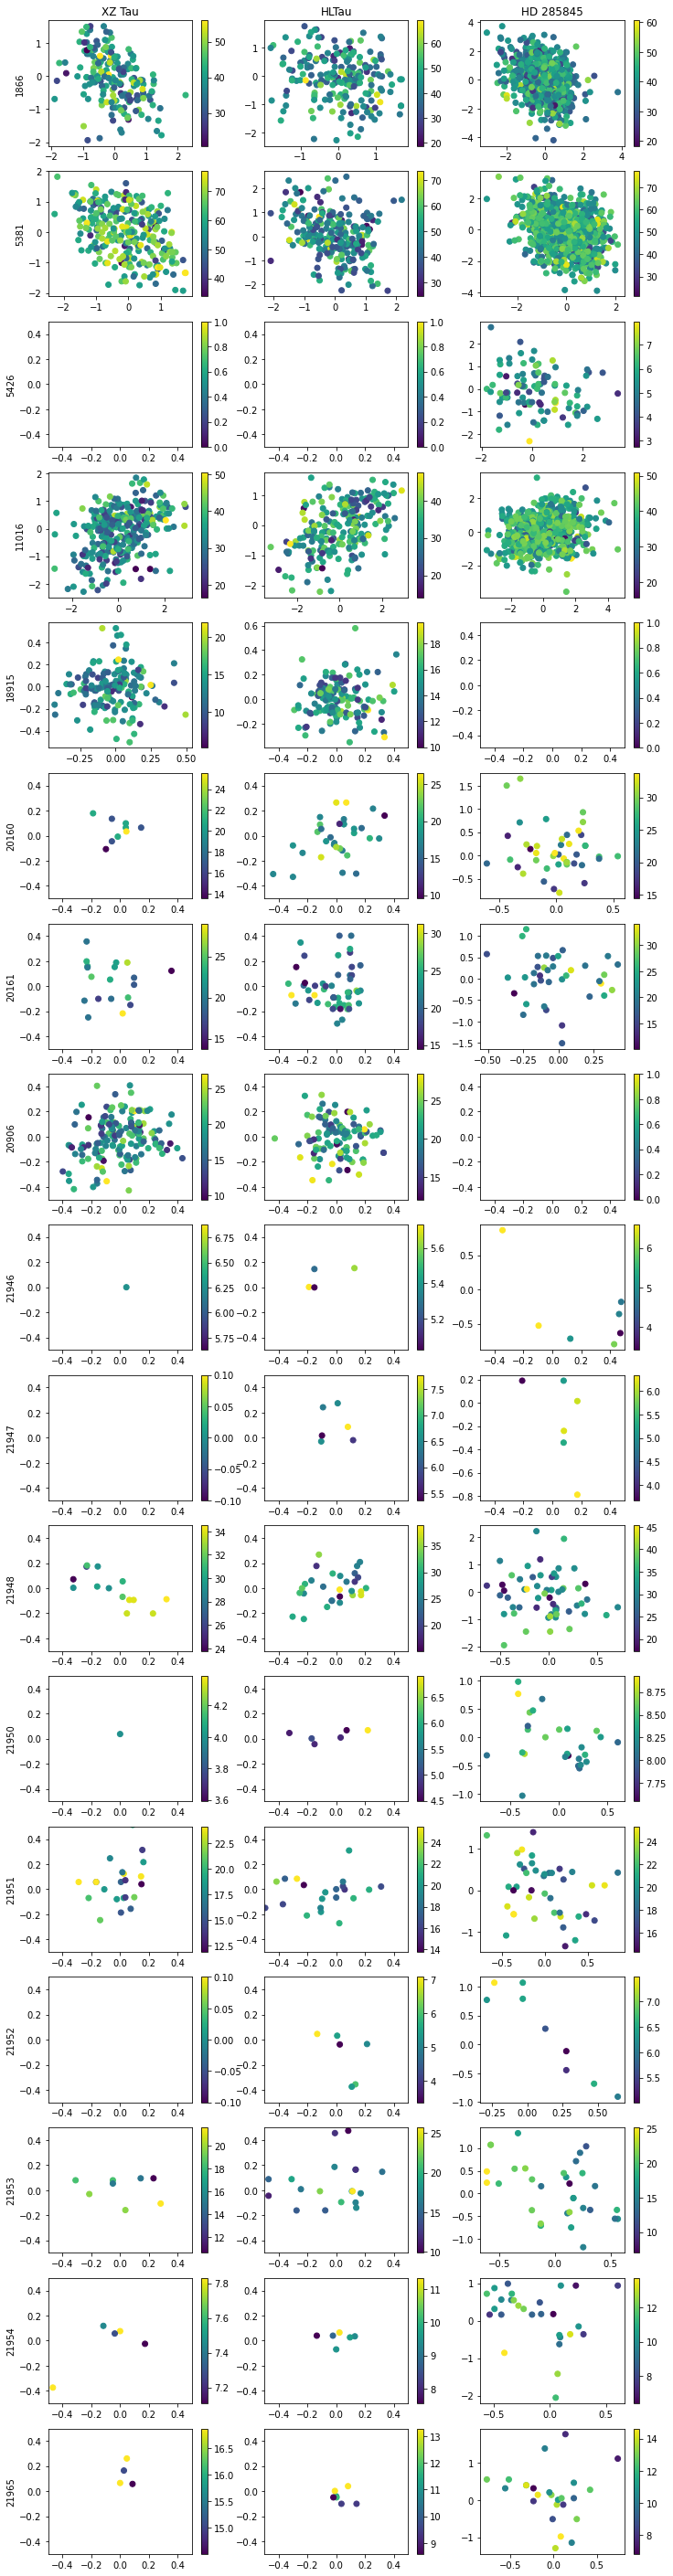

In [261]:
fig, axes = plt.subplots(figsize=(12, len(XZTauObs) * 3), ncols=3, nrows=len(XZTauObs))
for i, o in enumerate(XZTauObs['obsid']):
    pevts = filter_evt(o, coos)
    plot_evt(pevts, axes[i], 'time')
    axes[i, 0].set_ylabel(o)
    
for ax, t in zip(axes[0, :], XZTaunames):
    ax.set_title(t)

Except for maybe 21948, I don't see any pattern that indicates that the centroid changes with time. Would be interesting to look into 21948 a little more in details to see if that's just noise or if it means anything. However, I'm skeptical. Looking at some many plots with so few points, at some point (ha!) there must be a case where the points line up like ducks in a row just by chance.

Also note that thse plots are made with a rolling window size of 25, but every tenth point is shown in the scatter plot. That means that points shown are not independent. 

I experimented with different sizes for the rolling window and, based on DG Tau, I find that the best results are for rolling window sizes about 100 or so. However, in XZ Tau, we don't have enough counts to do that in most cases, so we have to settle for less.

## A close look at Obsid 21948

In [513]:
pevt = filter_evt(21948, [cooXZTau])[0]

Text(0, 0.5, 'energy [keV]')

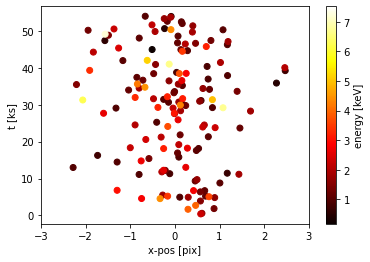

In [514]:
plt.set_cmap('hot')
plt.scatter(pevt['x'] - pevt['x'].mean(), pevt['time'], c=pevt['energy'])
plt.colorbar()
plt.xlim(-3, 3)
plt.ylabel('t [ks]')
plt.xlabel('x-pos [pix]')
plt.gcf().axes[-1].set_ylabel('energy [keV]')

In [515]:
from astropy.visualization import hist

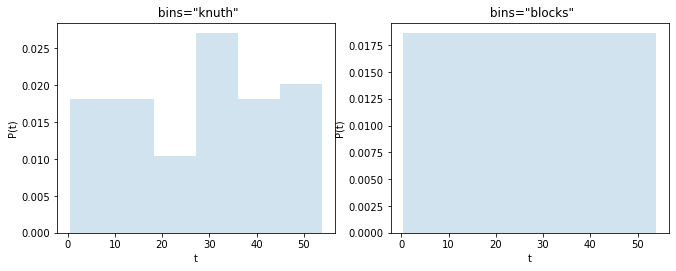

In [516]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

t = pevt['time']

fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
for i, bins in enumerate(['knuth', 'blocks']):
    hist(t, bins=bins, ax=ax[i], histtype='stepfilled',
            alpha=0.2, density=True)
    ax[i].set_xlabel('t')
    ax[i].set_ylabel('P(t)')
    ax[i].set_title(f' bins="{bins}"')


## Simulations: What difference in spectrum is needed to see an effect?

In this section, I simulate spectra from two different souces. I will use the Chandra ARFs and RMFs that we get for one of the HETG observations. The details don't matter that much since we are going to compare two sources next to each other, except for the increasing contamination of ACIS will blocks out the lower energies. That matters because a comparison of the softest photons just won't happen today because no or very little signal is detected. 

Here is the setup: I fake spectra with Sherpa and then draw energies from from simulated spectra. Then, I will draw a spatial position from HL Tau (which is close on the focal plane so it should have a similar PSF) for XZ Tau A or for XY Tau B I will simply add 0.3 arcsec in one direction. This method ignores the energy dependence of the PSF but that's hopefully a small effect.

In [517]:
# Make ARF and RMF for one obsid
obsid = 20906

In [518]:
curdir = os.path.abspath(os.curdir)
os.chdir('data')
download_chandra_obsids([obsid], filetypes=['asol', 'bpix', 'msk'])
os.chdir(curdir)

In [519]:

evtwcs = obsid_wcs(obsid)

hltau = SkyCoord.from_name('HL Tau')
evtfile = glob(f'data/{obsid}/primary/acisf{obsid:05d}*evt2.fits.gz')[0]

x, y = evtwcs.all_world2pix(hltau.ra, hltau.dec, 1)

rt.specextract.punlearn()
rt.specextract(infile=f"{evtfile}[sky=circle({x},{y},2)]", outroot=f'data/{obsid}/HLTau',
               weight=False, correctpsf=False)

OSError: An error occurred while running 'specextract':
  Running specextract
  Version: 18 November 2021
  
  Aspect solution file data/20906/primary/pcadf20906_000N001_asol1.fits found.
  
  Bad pixel file data/20906/primary/acisf20906_000N002_bpix1.fits.gz found.
  
  Mask file data/20906/secondary/acisf20906_000N002_msk1.fits found.
  
  Setting bad pixel file 
  
  Extracting src spectra 
  
  # specextract (18 November 2021): ERROR Failed to extract spectrum for data/20906/primary/acisf20906N002_evt2.fits.gz[sky=circle(4085.728316513069,4095.462433887631,2)]

In [520]:
from numpy.random import default_rng

from sherpa.astro.xspec import XSapec, XSphabs
from sherpa.astro.plot import DataPHAPlot
from sherpa.astro.io import read_pha
rng = default_rng()

In [521]:
# Read PHA file, because then I don't have to set up meta-data 
# (like the number of channels) by hand and arf and rmf are loaded 
# automatically based on the header keywords
simdata = read_pha('data/20906/HLTau.pi')

read ARF file data/20906/HLTau.arf
read RMF file data/20906/HLTau.rmf


In [522]:
modabs = XSphabs('abs')
modapec = XSapec('apec')

modabs.nH = 10
modapec.kT = 1.

modstar = modabs + modapec

modstar

<BinaryOpModel model instance '(abs + apec)'>

In [523]:
astro.fake.fake_pha(simdata, modstar)

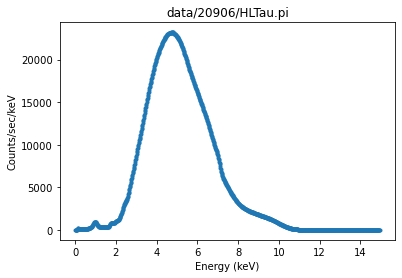

In [524]:
dplot = DataPHAPlot()
dplot.prepare(simdata)
dplot.plot()

In [525]:
pevts = filter_evt(obsid, [SkyCoord.from_name("HL Tau")])[0]

In [526]:
n = 500

In [527]:
sim_src_a = Table({'x': rng.choice(pevts['x'], size=n),
                   'y': rng.choice(pevts['y'], size=n),
                   'energy': rng.choice(dplot.x, size=n, replace=True, 
                                        p=simdata.counts / simdata.counts.sum()),
                   })
                   

In [528]:
def sim_src(n, model):
    astro.fake.fake_pha(simdata, model)
    # Preparing a plot is a easiest way to ge the energy and counts numbers
    # in an array of the correct shape
    dplot = DataPHAPlot()
    dplot.prepare(simdata)
    sim_src = Table({'x': rng.choice(pevts['x'], size=n),
                   'y': rng.choice(pevts['y'], size=n),
                   'energy': rng.choice(dplot.x, size=n, replace=True, 
                                        p=simdata.counts / simdata.counts.sum()),
                   })
    return sim_src

### Change in nH
In the next few example, I run the sumulation for sources A and B.  In this case, all that's changing is te n_h of the input component.

In [529]:
modabs.nH = 10
modapec.kT = 1.
srcA = sim_src(500, modstar)

modabs.nH = .1
modapec.kT = 1.
srcB = sim_src(500, modstar)
#srcB['x'] += 0.3 / 0.493  # offset 0.3" in one direction in Chandra pixels

simpevt_control = vstack([srcA, srcB]).to_pandas()

In [530]:
modabs.nH = 1.
modapec.kT = 1.
srcA = sim_src(500, modstar)

modabs.nH = .1
modapec.kT = 1.
srcB = sim_src(500, modstar)
srcB['x'] += 0.3 / 0.493  # offset 0.3" in one direction in Chandra pixels

simpevtnh1 = vstack([srcA, srcB]).to_pandas()

In [531]:
modabs.nH = .5
modapec.kT = 1.
srcA = sim_src(500, modstar)

modabs.nH = .1
modapec.kT = 1.
srcB = sim_src(500, modstar)
srcB['x'] += 0.3 / 0.493  # offset 0.3" in one direction in Chandra pixels

simpevtnh2 = vstack([srcA, srcB]).to_pandas()

In [532]:
modabs.nH = .1
modapec.kT = 1.
srcA = sim_src(500, modstar)

modabs.nH = .1
modapec.kT = 1.
srcB = sim_src(500, modstar)
srcB['x'] += 0.3 / 0.493  # offset 0.3" in one direction in Chandra pixels

simpevtnh3 = vstack([srcA, srcB]).to_pandas()

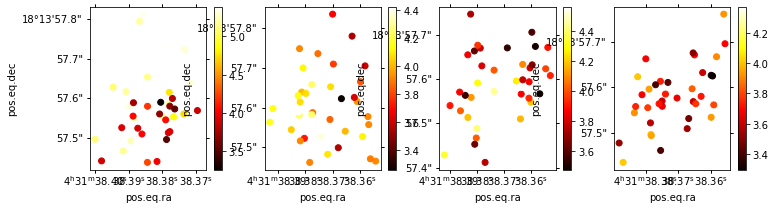

In [533]:
fig = plt.figure(figsize=(12, 3))
axes = [fig.add_subplot(1, 4, i, projection=evtwcs) for i in range (1, 5)]
plot_evt([simpevt_control, simpevtnh1, simpevtnh2, simpevtnh3],
          axes, window=50, spacing=slice(None, None, 25))



Panels are numbered left to right:

1. Control simulation. Sources are different but have offset=0 so not 
2. NH = 1.0 in one source and 0.1 in the other
3. nH differt by factor of five
4. control group 2 - sources are spatially offset a little, but spectra are identical.

Note: For simplicity, the offset of A and B is in x direction only and not diagonal in XY.

In [534]:
for o, pevt in zip(['no extension', '0.3 arcsec, different nH',
                    '0.3 arcsec, similar nH', '0.3 arcsec, same nH'], 
                   [simpevt_control, simpevtnh1, simpevtnh2, simpevtnh3]):
    print('OBSID:', o)
    print('x - std:', pevt.x.std())
    print('y - std:', pevt.y.std())

OBSID: no extension
x - std: 1.3469115
y - std: 1.1814795
OBSID: 0.3 arcsec, different nH
x - std: 1.1945995
y - std: 1.421124
OBSID: 0.3 arcsec, similar nH
x - std: 1.3553842
y - std: 1.2399108
OBSID: 0.3 arcsec, same nH
x - std: 1.3340076
y - std: 1.1834158


We see that the standard deviation is not a good indicator of having to separate sources. The simulation does not include a source extension gives results that seem very similar to the simulations with no source extension. I interactively played around with different extensions and found that distances > 1 arcsec are needed to reliably show up as larger standard deviations.

So, it's perhaps not surprising that we don't see that in the real data and I won't use this metric any more.

### Change in normalization

In [535]:
modstar

<BinaryOpModel model instance '(abs + apec)'>

In [536]:
modabs.nH = 1.
modapec.kT = 1.
srcA = sim_src(5000, modstar)

modabs.nH = .1
modapec.kT = 1.
srcB = sim_src(5000, modstar)
srcB['x'] += 0.3 / 0.493  # offset 0.3" in one direction in Chandra pixels

simpevtnorm1 = vstack([srcA, srcB]).to_pandas()

In [537]:
modabs.nH = 1
modapec.kT = 1.
srcA = sim_src(800, modstar)

modabs.nH = .1
modapec.kT = 1.
srcB = sim_src(200, modstar)
srcB['x'] += 0.3 / 0.493  # offset 0.3" in one direction in Chandra pixels

simpevtnorm2 = vstack([srcA, srcB]).to_pandas()

In [538]:
modabs.nH = 1
modapec.kT = 2.
srcA = sim_src(500, modstar)

modabs.nH = .1
modapec.kT = .2
srcB = sim_src(500, modstar)
srcB['x'] += 0.3 / 0.493  # offset 0.3" in one direction in Chandra pixels

simpevttemp = vstack([srcA, srcB]).to_pandas()

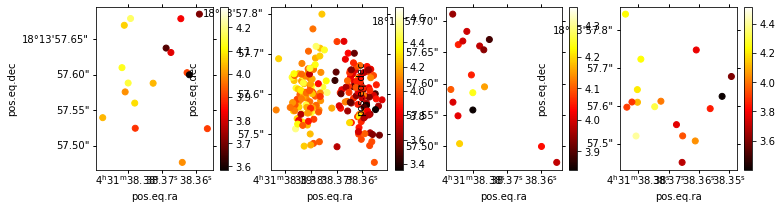

In [539]:
fig = plt.figure(figsize=(12, 3))
axes = [fig.add_subplot(1, 4, i, projection=evtwcs) for i in range (1, 5)]
plot_evt([simpevtnh1, simpevtnorm1, simpevtnorm2, simpevttemp],
          axes, window=100, spacing=slice(None, None, 50))



Panels left to right:

1. panel 2 from above (nH different)
2. same as panel 1, but with 10000 counts intead of 1000 for both sources combined
3. 1000 counts combined, but instead of distributing 50:50 as in the other plots, do 80:20
4. 1000 counts again, 50:50 distributed, but this time with a larger difference in input spectrum (changing kT as well as nH).

### What are the lessons here?

These type of plot work (see the real data of DG Tau above) as well as these simulations, but one needs a difference in spectral shape, and a sufficient number of counts. There is little overlap. This measure switches to the position of the source that dominates at one spectral range, so if the second source never dominates the spectrum, then it's not really visible.

The mean can be better for that - but it's also not a robust in the presence of noise.
(I've run most fo the code above twice, modifying the definition of `plot_evt` to use either the mean or the median. but I only keep one version saved in the notebook. Change the code and re-run to see the difference.)

## Last ditch attempt: Merge observations
There are of course sohisticated ways of merging observations, but let's try something simple here. We just get the median x/y from HL Tau (hoepfully a point source) in that observation and then we plot the XZ Tau photons simply as the offset from HL Tau. Given the different field rotations, we have to do that in RA/Dec and can't just use x,y. That means a little more bookkeeping of coordinate systems, but it's not a big problem in principle. 

In [560]:
evtfile = glob(f'data/{obsid}/primary/acisf{obsid:05d}*evt2.fits.gz')
evts = Table.read(evtfile[0], hdu=1, format='fits')
evtwcs = obsid_wcs(obsid)

In [559]:
evts

time,ccd_id,node_id,expno,chipx,chipy,tdetx,tdety,detx,dety,x,y,pha,pha_ro,energy,pi,fltgrade,grade,status [32]
s,,,,pix,pix,pix,pix,pix,pix,pix,pix,adu,adu,eV,chan,,,
float64,int16,int16,int32,int16,int16,int16,int16,float32,float32,float32,float32,int32,int32,float32,int32,int16,int16,bool
630779675.6568362,7,3,4,830,592,4747,2294,4704.903,4036.7314,4298.9707,4659.288,2286,2204,10213.55,700,2,2,False .. False
630779675.7389162,8,0,4,154,503,5113,2205,5070.6167,4125.044,4309.3633,5035.35,3242,2971,14010.805,960,16,4,False .. False
630779677.5389062,7,3,6,811,495,4728,2197,4685.98,4132.8457,4201.695,4666.01,2499,2415,11163.551,765,64,2,False .. False
630779678.4799463,7,0,7,217,426,4134,2128,4092.8271,4202.066,3980.0664,4111.4707,2544,2468,11360.339,779,64,2,False .. False
630779679.4209665,7,2,8,625,453,4542,2155,4500.256,4174.8833,4112.7476,4497.773,3360,3263,15541.025,1024,64,2,False .. False
630779679.4620064,6,0,8,15,448,2890,2150,2847.62,4180.86,3675.0916,2904.1301,481,402,1909.1006,131,72,6,False .. False
630779681.3030366,7,3,10,790,626,4707,2328,4665.3193,4002.4175,4322.456,4612.201,1979,1892,8853.143,607,16,4,False .. False
630779681.3030366,7,3,10,987,626,4904,2328,4861.671,4002.3135,4373.869,4801.702,3280,3222,14619.925,1002,0,0,False .. False


In [561]:
ra, dec = evtwcs.all_pix2world(evts['x'], evts['y'], 1)

In [563]:
pevts = filter_evt(o, coos)

In [568]:
ra_hltau, dec_hltau = evtwcs.all_pix2world(np.median(pevts[1]['x']), np.median(pevts[1]['y']), 1)
ra_xztau, dec_xztau = evtwcs.all_pix2world(pevts[0]['x'], pevts[0]['y'], 1)
pevts[0]['delta_ra'] = ra_xztau - ra_hltau
pevts[0]['delta_dec'] = (dec_xztau - dec_hltau) * np.cos(np.deg2rad(dec_hltau))

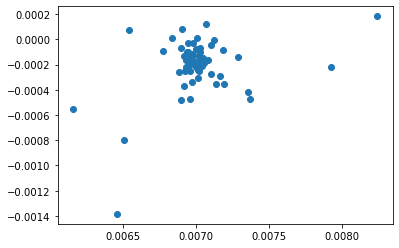

In [571]:
plt.scatter(pevts[0]['delta_ra'], pevts[0]['delta_dec'])

In [572]:
cooA = SkyCoord.from_name('XZ Tau')
cooB = cooA.spherical_offsets_by(-0.215 * u.arcsec, 0.157 * u.arcsec)

xztau = []

for i, o in enumerate(XZTauObs['obsid']):
    evtwcs = obsid_wcs(obsid)
    axes = [fig.add_subplot(len(XZTauObs), 3, i * 3 + j + 1, projection=evtwcs) for j in range(3)]
    pevts = filter_evt(o, coos)
    ra_hltau, dec_hltau = evtwcs.all_pix2world(np.median(pevts[1]['x']), np.median(pevts[1]['y']), 1)
    ra_xztau, dec_xztau = evtwcs.all_pix2world(pevts[0]['x'], pevts[0]['y'], 1)
    pevts[0]['delta_ra'] = ra_xztau - ra_hltau
    pevts[0]['delta_dec'] = (dec_xztau - dec_hltau) * np.cos(np.deg2rad(dec_hltau))
    xztau.append(pevts[0])

/Users/guenther/mambaforge/envs/i386ciao-4.14/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [586]:
# First few observations are vastly off-axis
# So, we merge only the latter ones
xzmerged = pandas.concat(xztau[4:])

Text(0, 0.5, '$\\Delta$Dec (compared to HL Tau) in arcsec')

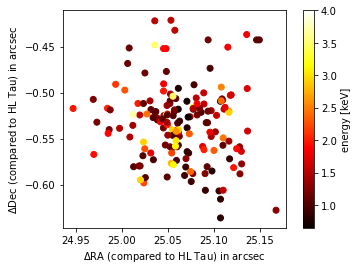

In [589]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect=1)

xzmerged.sort_values('energy')

spacing = slice(None, None, 25)
window = 100

rolled = xzmerged.rolling(window).apply(np.median)
scat = ax.scatter(rolled['delta_ra'][spacing] * 3600, rolled['delta_dec'][spacing] * 3600,
                          c=rolled['energy'][spacing], alpha=1)
cbar = plt.colorbar(scat, ax=ax)
cbar.set_label('energy [keV]')

ax.set_xlabel('$\Delta$RA (compared to HL Tau) in arcsec')
ax.set_ylabel('$\Delta$Dec (compared to HL Tau) in arcsec')

I don't see a trend here. Sure, I want to see one and if I squint hard enough, I'm sure I can make something ouy. However, that's probably not significant and certianly nowhere as clear as in the DG Tau data above.